<a href="https://colab.research.google.com/github/alehb80/skin-lesion-classification/blob/master/skin_lesion_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKIN LESION CLASSIFICATION

## 1. Building

### Import API Kaggle

In [0]:
!pip install -q kaggle

In [0]:
!mkdir  ~/.kaggle
!touch ~/.kaggle/kaggle-5.json

api_token = {"username":"gianlucavisentin","key":"c609dca13d58751e6fc9d489a0dddb2d"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!pip install --upgrade --force-reinstall --no-deps kaggle

### Download Dataset

In [0]:
!kaggle datasets list -s skin

In [0]:
# Copy the dataset locally
!kaggle datasets download --force -d kmader/skin-cancer-mnist-ham10000

In [0]:
!unzip skin-cancer-mnist-ham10000.zip

### Import Libraries

In [9]:
# Matrix and dataframe manipulation
import numpy as np
import pandas as pd

# Image operations and plotting
from PIL import Image
from skimage.io import imread, imshow
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

# File, path and directory operations
import os
from glob import glob

# Data augmentation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Model building
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

# Data preparation
from sklearn.model_selection import train_test_split

# For aesthetics
import warnings
warnings.filterwarnings('ignore')

# Others
from keras.utils.np_utils import to_categorical

# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


### Build Dataframe

In [0]:
# merge the images in jpg format from both the folders
base_skin_dir = "./"
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [11]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(6)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9520,HAM_0005353,ISIC_0032923,nv,consensus,30.0,male,back,./HAM10000_images_part_2/ISIC_0032923.jpg,Melanocytic nevi,4
1994,HAM_0002622,ISIC_0030187,mel,histo,35.0,male,upper extremity,./HAM10000_images_part_2/ISIC_0030187.jpg,Melanoma,5
5136,HAM_0006981,ISIC_0029451,nv,follow_up,45.0,female,foot,./HAM10000_images_part_2/ISIC_0029451.jpg,Melanocytic nevi,4
6377,HAM_0001795,ISIC_0030611,nv,follow_up,30.0,female,upper extremity,./HAM10000_images_part_2/ISIC_0030611.jpg,Melanocytic nevi,4
57,HAM_0003569,ISIC_0026955,bkl,histo,75.0,male,unknown,./ham10000_images_part_1/ISIC_0026955.jpg,Benign keratosis-like lesions,2
6658,HAM_0005402,ISIC_0031695,nv,follow_up,45.0,female,upper extremity,./HAM10000_images_part_2/ISIC_0031695.jpg,Melanocytic nevi,4


## 2. Introduction

### Problem Description

#### View image samples

In [0]:
# Display 5 examples of each cell type
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=108).iterrows()):
        c_ax.imshow(imread(c_row['path']))
        c_ax.axis('off')

### Project Goal

## 3. Data Exploration

### Dataset Description

In [12]:
tile_df.duplicated('image_id').any()

False

### Data Distribution Visualization

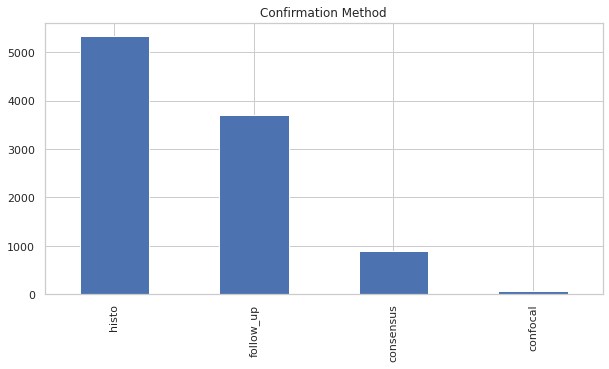

In [13]:
# Plot the distibution of groud truth confirmation method
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['dx_type'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Confirmation Method');

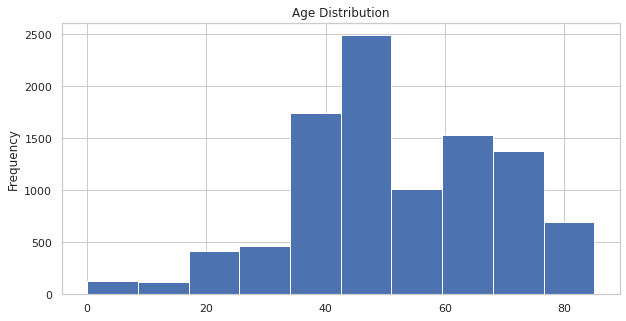

In [14]:
# Plot the age distribution
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['age'].plot(kind='hist', ax=ax1)
ax1.set_title('Age Distribution');

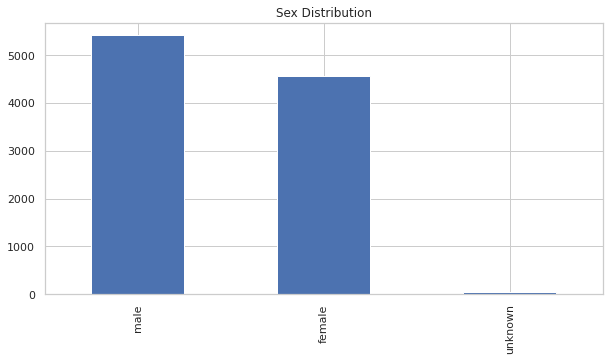

In [15]:
# Plot the sex distibution
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['sex'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Sex Distribution');

In [16]:
# Since we are not going to use the meta data in our final model, let's just replace 'unknown' 
# values with 'male'. We could consider dropping these if we were going to use the metadata
tile_df['sex'].replace(to_replace='unknown', value='male', inplace=True)
tile_df['sex'].value_counts()

male      5463
female    4552
Name: sex, dtype: int64

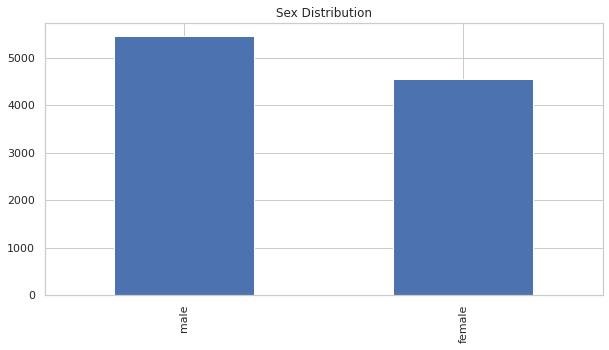

In [17]:
# Plot the sex distibution
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['sex'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Sex Distribution');

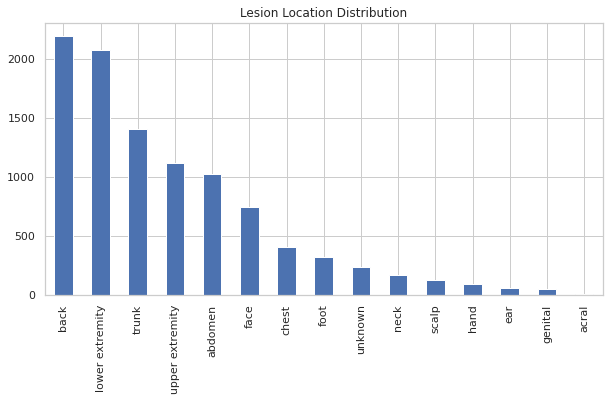

In [18]:
# Plot the distibution of lesion location
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['localization'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Lesion Location Distribution');

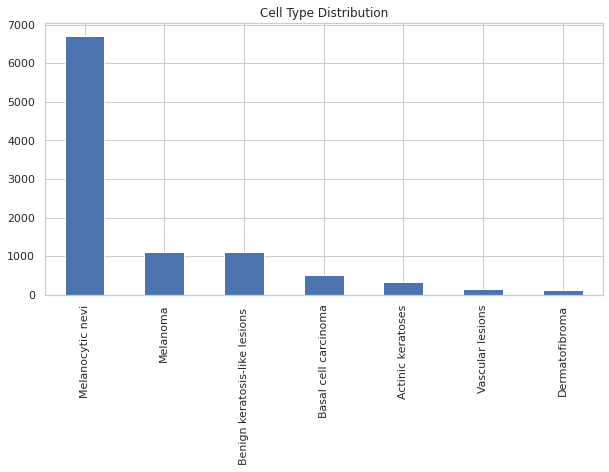

In [19]:
# Plot the distibution of cell types represented in the dataset
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Cell Type Distribution');

### RGB Pixel Distribution

## 4. Baseline

### Data Cleaning

In [20]:
# show if there is a null data
tile_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [21]:
# calculate te mean value of the "age" feature
print(tile_df['age'].mean())

51.863828077927295


In [0]:
# fill the null values by their mean
tile_df['age'].fillna((tile_df['age'].mean()), inplace=True)

In [23]:
# show if there is a null data
tile_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

### Loading and resize images

In [0]:
# resize the images to 100 * 75 which tensorflow can handle
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [25]:
# checking the image size distribution
tile_df['image'].map(lambda x: x.shape)

0        (75, 100, 3)
1        (75, 100, 3)
2        (75, 100, 3)
3        (75, 100, 3)
4        (75, 100, 3)
             ...     
10010    (75, 100, 3)
10011    (75, 100, 3)
10012    (75, 100, 3)
10013    (75, 100, 3)
10014    (75, 100, 3)
Name: image, Length: 10015, dtype: object

### Dataset Building

#### Split data into train and test with 80:20 ratio

In [0]:
features = tile_df.drop(columns=['cell_type_idx'],axis=1)
target = tile_df['cell_type_idx']

# 'train_test_split' splits arrays or matrices into random train and test subsets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

#### Normalization

In [0]:
# subtract their mean values from it and then dividing by their standard deviation
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

#### Label Encoding

In [0]:
# labels are 7 different classes of cell types from 0 to 6. We need to encode these lables to one hot vectors
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#### Training and Validation Split

In [0]:
# validate:train >> 10:90 %
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2)

In [0]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

### Model Building

In [0]:
input_shape = (75, 100, 3)
num_classes = 7
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.55),
    
    Dense(7, activation='softmax')
])

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 64)        0

### Data Augmentation (Avoid the overfitting)

In [0]:
# avoiding the overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False
        )  # randomly flip images
datagen.fit(x_train)

### Model Training

In [37]:
epochs = 50 
batch_size = 10
history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
640/640 [==============================] - 17s 26ms/step - loss: 0.2412 - accuracy: 0.6627 - val_loss: 0.2143 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 2/50
640/640 [==============================] - 16s 26ms/step - loss: 0.2167 - accuracy: 0.6698 - val_loss: 0.2026 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 3/50
640/640 [==============================] - 16s 26ms/step - loss: 0.2121 - accuracy: 0.6754 - val_loss: 0.2140 - val_accuracy: 0.6843 - lr: 0.0010
Epoch 4/50
640/640 [==============================] - 16s 26ms/step - loss: 0.2063 - accuracy: 0.6776 - val_loss: 0.1929 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 5/50
640/640 [==============================] - 16s 26ms/step - loss: 0.2031 - accuracy: 0.6781 - val_loss: 0.1987 - val_accuracy: 0.6925 - lr: 0.0010
Epoch 6/50
640/640 [==============================] - 16s 26ms/step - loss: 0.2032 - accuracy: 0.6825 - val_loss: 0.2091 - val_accuracy: 0.

### Model Evaluation

In [56]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

51/51 [==============================] - 1s 15ms/step - loss: 0.1711 - accuracy: 0.7324
Validation: accuracy = 0.732377  ;  loss_v = 0.171062
Test: accuracy = 0.724913  ;  loss = 0.179054


In [0]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

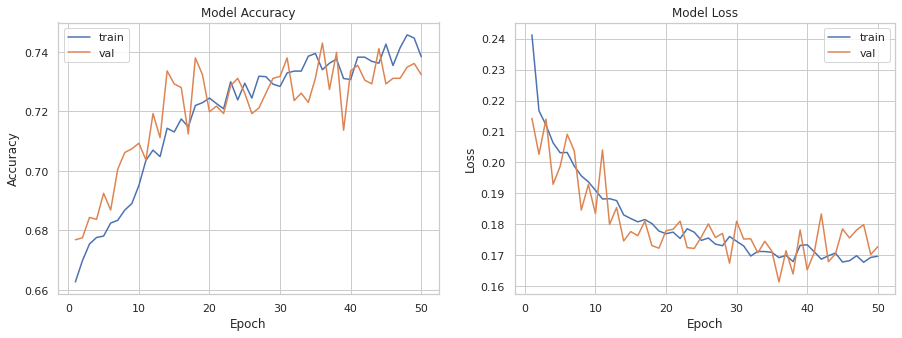

In [60]:
plot_model_history(history)

## 5. Our Contribution

### Data Pre-Processing

#### Avoid Duplicates In Test And Validation Sets // TO-DO

In [0]:
tile_df[tile_df["lesion_id"] == "HAM_0000002"]

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
1660,HAM_0000002,ISIC_0033848,mel,histo,65.0,female,lower extremity,./ham10000_images_part_2/ISIC_0033848.jpg,Melanoma,5
1661,HAM_0000002,ISIC_0032622,mel,histo,65.0,female,lower extremity,./ham10000_images_part_2/ISIC_0032622.jpg,Melanoma,5
1662,HAM_0000002,ISIC_0034246,mel,histo,65.0,female,lower extremity,./ham10000_images_part_2/ISIC_0034246.jpg,Melanoma,5


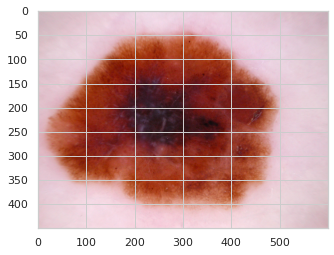

In [0]:
plt.imshow(imread('./ham10000_images_part_2/ISIC_0033848.jpg'))

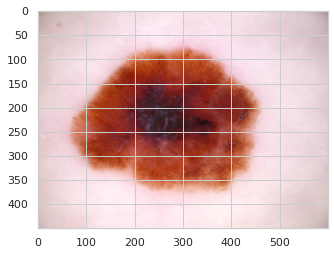

In [0]:
plt.imshow(imread('./ham10000_images_part_2/ISIC_0032622.jpg'))

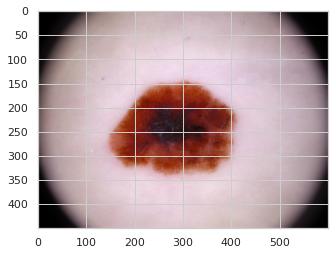

In [0]:
plt.imshow(imread('./ham10000_images_part_2/ISIC_0034246.jpg'))

#### Data Augmentation //TODO

#### Evaluation

### Model Building (new architecture)

#### 1. CNN

In [0]:
# Our input feature map is 75x100x3: 75x100 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(75, 100, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and softmax activation
output = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model
model = Model(img_input, output)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
def get_call_back():
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                          factor=0.5, 
                                           min_lr=0.00001)
  return[reduce_lr]



In [0]:
model.summary()

#### 2. MobileNet

In [0]:
#-------------------------------model------------------------------
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
mobile = keras.applications.mobilenet.MobileNet(input_shape=(75,100,3), include_top=False)
x = mobile.layers[-6].output
# Add a dropout and dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)
print(mobile.input)
Model = Model(inputs=mobile.input, outputs=predictions)
mobile.summary()
for layer in Model.layers[:-23]:
  layer.trainable = False
Model.compile(optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator  
datagen = ImageDataGenerator()

it = datagen.flow(x_train,y_train)

#bisogna capire per quanto farla runnare
model.fit(it,steps_per_epoch=128,epochs=10)



In [0]:
model.summary()

### Hyperparam Tunes

#### Grid Search

### Model Training

In [0]:
epochs = 30 
batch_size = 180
history = model.fit(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=get_call_back()
)

### Model Evaluation

In [0]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

In [0]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=160)
print('test loss, test acc:', results)

## 6. Assessing Performance

### k-fold Cross-Validation On Baseline

### k-fold Cross-Validation On New Model

### Evaluation